# Diabetes_diagnosis_in_patients_using_RNN (Scenario 2)

## Description
In the following problem, a set of medical data from different patients is presented. The objective is to determine whether or not the patient has diabetes based on certain medical indicators. All patients in the dataset are female.

## Aim
Using the constructed dataset, the objective is to build a classification model using neural networks that can accurately predict whether the patient in question has diabetes or not. The model must be trained and evaluated using appropriate validation techniques and classification evaluation metrics.

Se comienza por importar las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import gdown
import zipfile
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

2024-04-21 17:09:15.125152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:09:28.276701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1 - Análisis Exploratorio (EDA)

Se comenzará haciendo un análisis explotarorio del dataset para conocer sus características principales y evaluar si es necesario hacer algún manejo de datos faltantes, outliers, codificar variables categóricas, o algún otro proceso antes de comenzar.

Para esto se hallarán:

- Medidas de centralidad

- Cuartiles y percentiles

- Medidas de dispersión

- Valores atípicos

- Gráficos de proporciones y porcentajes


En esta primera etapa se obtendrá información sobre el dataset y se realizarán gráficos que permitan observar los datos sin realizar modificaciones previas sobre el set de datos, es decir, se analizará el dataset tal como proviene de la fuente.

### 1.1 - Importar el dataset y visualizar el dataframe

In [ ]:
# TP1-2-diabetes.zip
gdown.download('https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_')

In [93]:
with zipfile.ZipFile('TP1-2-diabetes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

In [94]:
diabetes_df = pd.read_csv('./TP1-2/diabetes.csv')

### Dataset

The dataset provided includes the following variables for each patient:

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration at 2 hours in an oral glucose tolerance test
- Blood pressure: Diastolic blood pressure (mm Hg)
- Skin thickness: Triceps skin fold thickness (mm)
- Insulin: Serum insulin at 2 hours (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- Diabetes pedigree function: Value that assesses the probability of diabetes based on family history.
- Age: Age (years)
- Outcome: target variable (0 for diabetes negative, 1 for positive).

In [7]:
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### 1.2 - Medidas estadísticas y de localización
En este paso se estudian, para cada columna, medidas de localización como mínimo, máximo, cuartiles, y de centralidad como la mediana y la media.

In [8]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Para las columnas analizadas, en general (excepto para la columna de insulina) se puede notar que la medida de la media es muy cercana a la mediana indicando que el valor promedio de los datos coincide con el valor central de la distribución. Los desvíos no suelen superar el 25% dando indicio de que la caja de un diagrama de boxplot no sería muy alargada, es decir, que no mostraría gran dispersión en los valores registrados.

Además, los valores mínimos y máximos registrados suelen estar muy alejados de los valores centrales, por lo que se espera presencia de valores atípicos.

Específicamente, en la columna que representa el nivel de insulina se observa una media, mediana, valor mínimo y máximo muy distintos y alejados. Se intuye debido a esto, que la media está fuertemente influenciada por valores atípicos y que el diagrama de cajas mostrará gran presencia de valores atípicos.  

### 1.3 - Datos faltantes
Aquí se utiliza otro método de Pandas para ver más claramente la cantidad de datos faltantes

In [9]:
# Identificar la cantidad de filas con datos faltantes para cada columna
missing_data = diabetes_df.isnull().sum()
print(missing_data)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Se observa que el tipo de dato de las columnas es número entero (int) y que no se encuentran valores faltantes.

### 1.4 - Visualización de Datos Numéricos


In [30]:
# Columnas numéricas
columns_names = diabetes_df.columns.to_list()
columns_names.remove('Outcome')
numeric_columns = columns_names

#### 1.4.1 - Gráficos de Caja y Bigotes
Para visualizar la distribución de las variables se realizaron gráficos de caja y bigote.

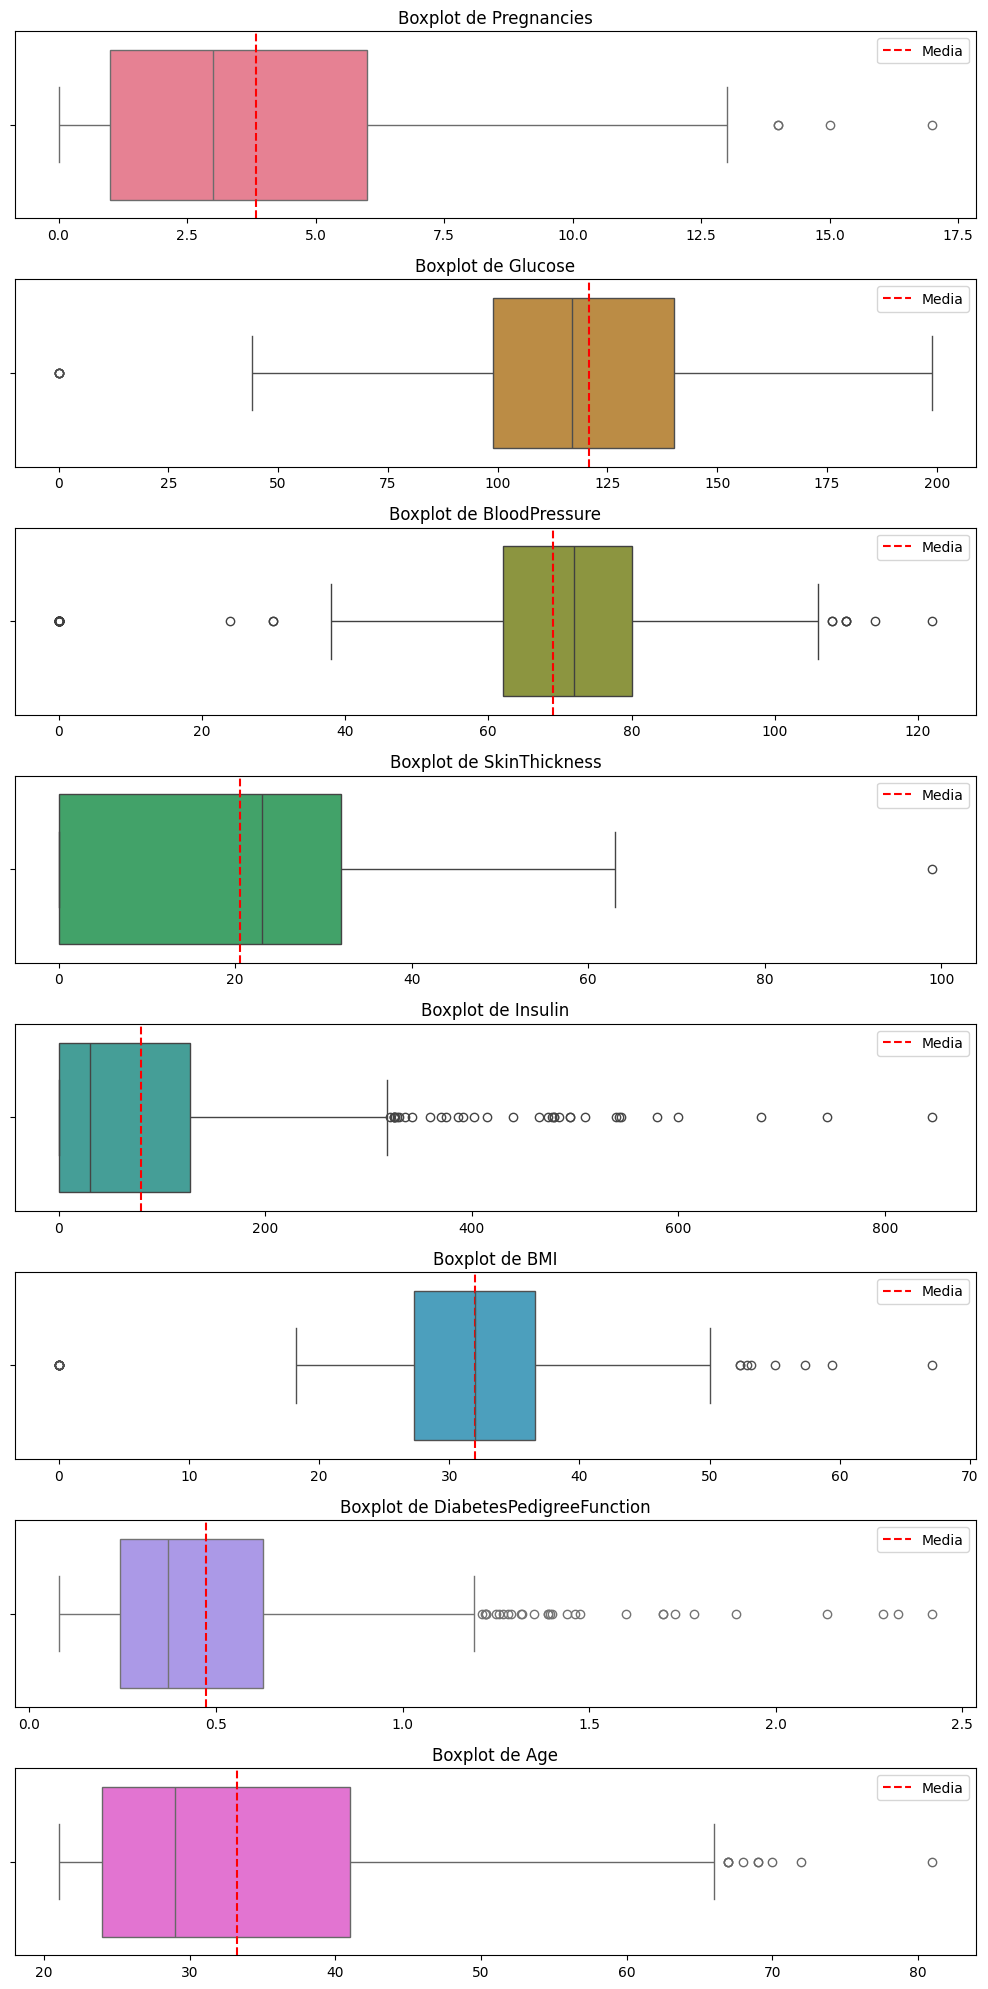

In [31]:
# Colores para los boxplots
colors = sns.color_palette('husl', n_colors=len(numeric_columns))

# Crear subplots
fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(10, 20), sharex=False)

# Generar boxplots horizontales para cada columna numérica
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=diabetes_df, x=col, ax=axes[i], color=colors[i], orient='h')
    
    # Calcular la media de la columna actual
    mean_value = diabetes_df[col].mean()
    
    # Dibujar una línea vertical en la posición de la media
    axes[i].axvline(x=mean_value, color='r', linestyle='--', label='Media')
    
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')  # Elimina la etiqueta del eje x para mayor claridad

    # Agregar leyenda
    axes[i].legend()

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

En la figura donde se representan los boxplot de las columnas del dataset se observa en la mayoría de ellas la presencia de valores atípicos. En algunas variables dichos valores se encuentran más alejados. Otras veces se encuentran más cercanos y hacia ambos lados del diagrama. Para las columnas Glucose y Skin Thickness se encuentra menor cantidad de presencia de valores atípicos, estando la mayoría de valores contenidos dentro del diagrama de cajas. Esto sugiere que la mayoría de los valores se encuentran dentro de un rango esperado. Esto puede indicar una mayor consistencia en la muestra o en el proceso de recolección de datos.

Las variables que presentan mayor amplitud en el boxplot, indicando mayor dispersión en los valores de los datos son Pregnancies. Skin Thickness y Age.  Esto puede indicar una mayor heterogeneidad en los datos. Lo que puede estar sucediendo con las variables Pregnancies y Skin Thickness es que, al ser la variable edad más dispersa, se estarían comparando varias categorías etáreas y, el alargamiento de los boxplots puede indicar diferencias significativas en la dispersión de los datos entre estos grupos. Esto podría sugerir que los grupos no son homogéneos en términos de la variable que se está analizando. Puede que haya correlación entre la variable Age y las otras dos.

Las demás variables presentan diagramas de caja más compactos, con menor dispersión de los datos. Esto puede significar que los datos están más agrupados alrededor de la mediana y que hay menos variabilidad entre los valores de la variable en cuestión. Esto podría sugerir una mayor homogeneidad en los datos o una menor variabilidad intrínseca en la variable que se está analizando.

#### 1.4.2 - Histogramas
Para visualizar las distribuciones de forma más detallada se realizaron también histogramas de cada una

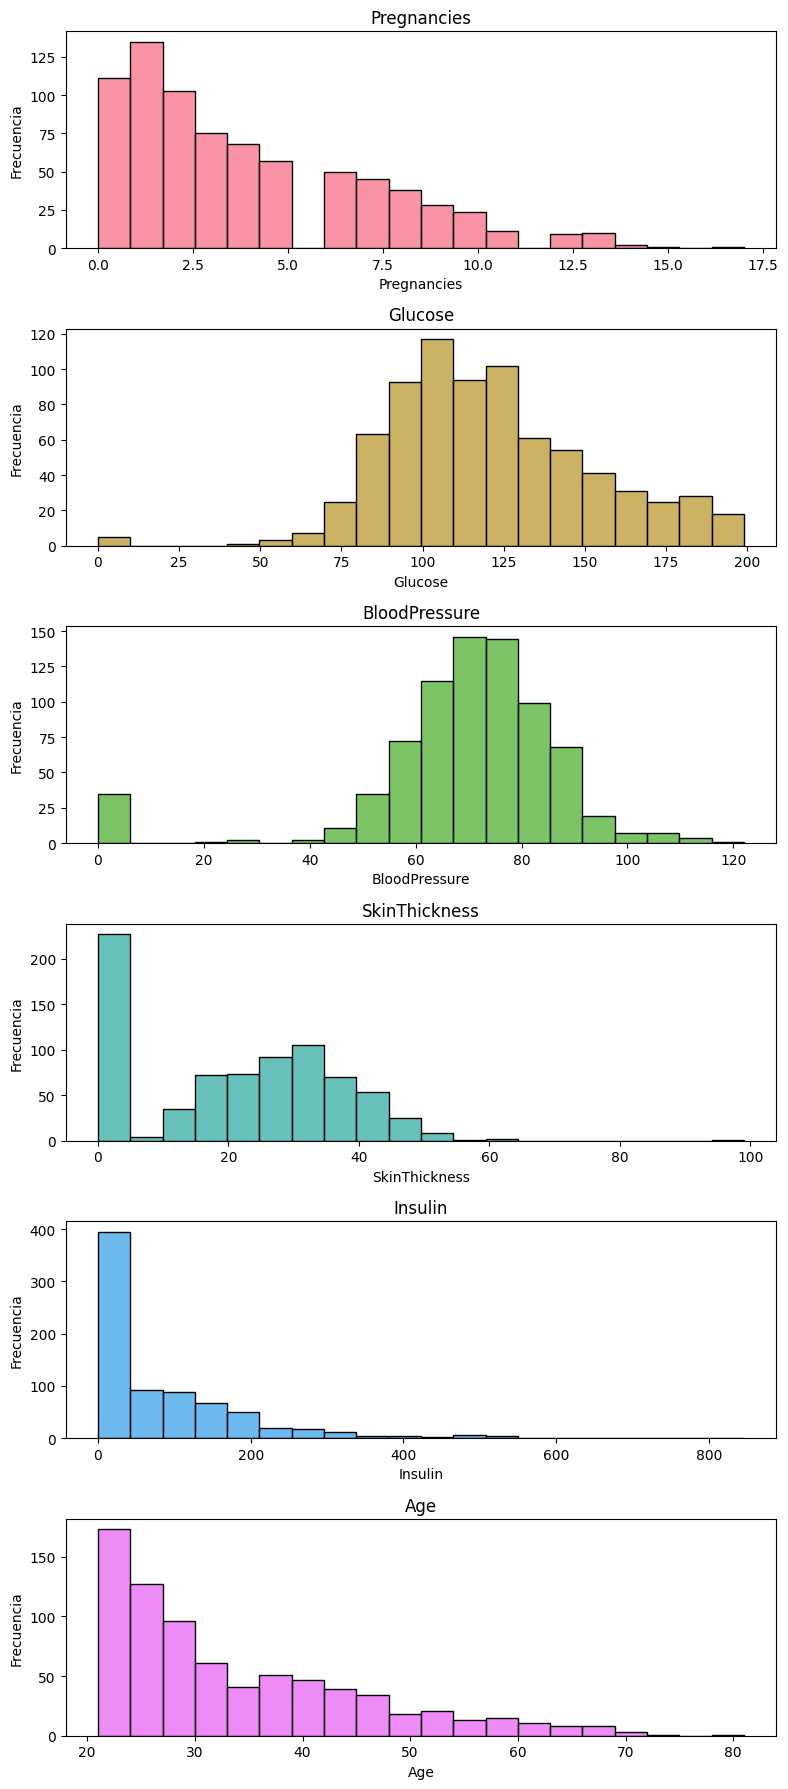

In [33]:
# Seleccionar las columnas numéricas excluyendo "RainfallTomorrow"
columns = diabetes_df.select_dtypes(include=['int']).drop(columns=['Outcome'])
# Configurar el número de subplots y el tamaño de la figura
num_plots = len(columns.columns)
fig, axes = plt.subplots(num_plots, 1, figsize=(8, num_plots * 3))

# Definir una paleta de colores para Seaborn
color_palette = sns.color_palette("husl", num_plots)

# Crear un histograma para cada columna numérica con colores distintos
for i, column in enumerate(columns.columns):
    ax = axes[i]
    sns.histplot(diabetes_df[column].dropna(), bins=20, color=color_palette[i], ax=ax)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los histogramas
plt.show()

Distribuciones sesgadas hacia la derecha (mediana a la izquierda de la media):

- Pregnancies: indica que la mayoría de las mujeres tuvo valores más bajos en cantidad de embarazos y algunas estuvieron embarazadas muchas veces.

- Insulin: indica que la mayor parte de las observaciones para los niveles de insulina estarían concentradas en valores más bajos. Aún así, en esta variable se encuentra la numerosa presencia de valores atípicos.

- DiabetesPedigreeFunction: indica que la mayor parte de las observaciones para los niveles de insulina estarían concentradas en valores más bajos, lo que mostraría probabilidades bajas probabilidades de diabetes por antecedentes 
familiares. Quizá no tienen familiares con diabetes o quizá no es tan influyente para el diagnóstico actual.

- Age: se encuentra que mayormente se ha estudiado a mujeres jóvenes y menor cantidad de personas adultas mayores.

Distribuciones sesgadas hacia la izquierda (mediana a la derecha de la media):

- Skin Thickness: Esto indicaría que la mayor parte de las observaciones de grosor de piel estaría concentrada en valores más altos, con una cola que se extiende hacia valores más bajos.

#### 1.4.3 - Violin plots por categoría

Se visualizarán las distribuciones de cada variable separadas por categoría con el objetivo de conocer si existe distinción entre los valores que asume la variable en base a cada categoría.

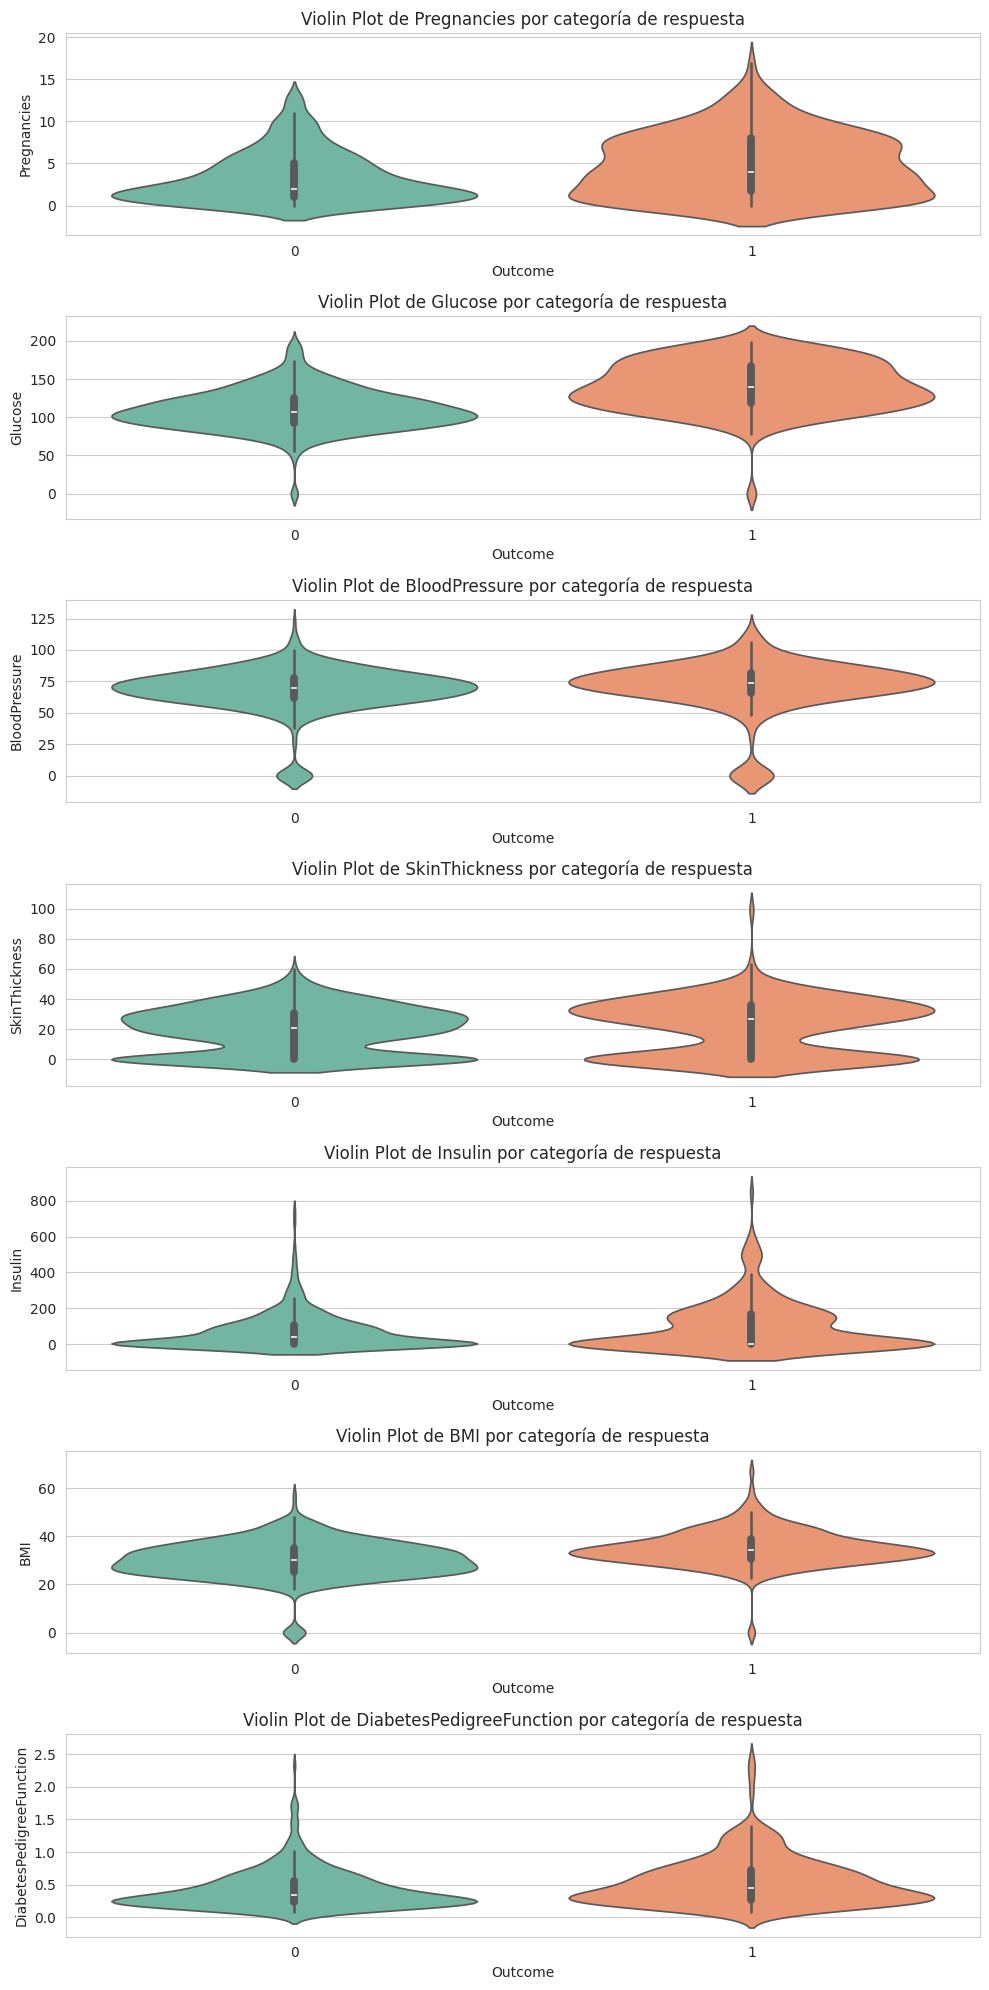

In [98]:
# Configurar estilo de seaborn
sns.set_style("whitegrid")

# Crear una figura y ejes de matplotlib
fig, axs = plt.subplots(len(numeric_columns) - 1, 1, figsize=(10, 20), sharex=False)

# Para cada variable excepto la variable de respuesta
for i, col in enumerate(numeric_columns[:-1]):
    # Crear un gráfico de violín para la variable, separado por la variable de respuesta
    sns.violinplot(x='Outcome', y=col, data=diabetes_df, ax=axs[i], palette='Set2')
    axs[i].set_title(f'Violin Plot de {col} por categoría de respuesta')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()


Se observa que cada variable tiene un comportamiento muy similar en ambas categorías. Aún así, puede mencionarse que las personas diagnosticadas con diabetes registran mayor cantidad de embarazos, niveles de glucosa, insulina y probabilidad de diabetes basada en antecedentes familiares.

#### 1.4.4 - Gráficas de correlación

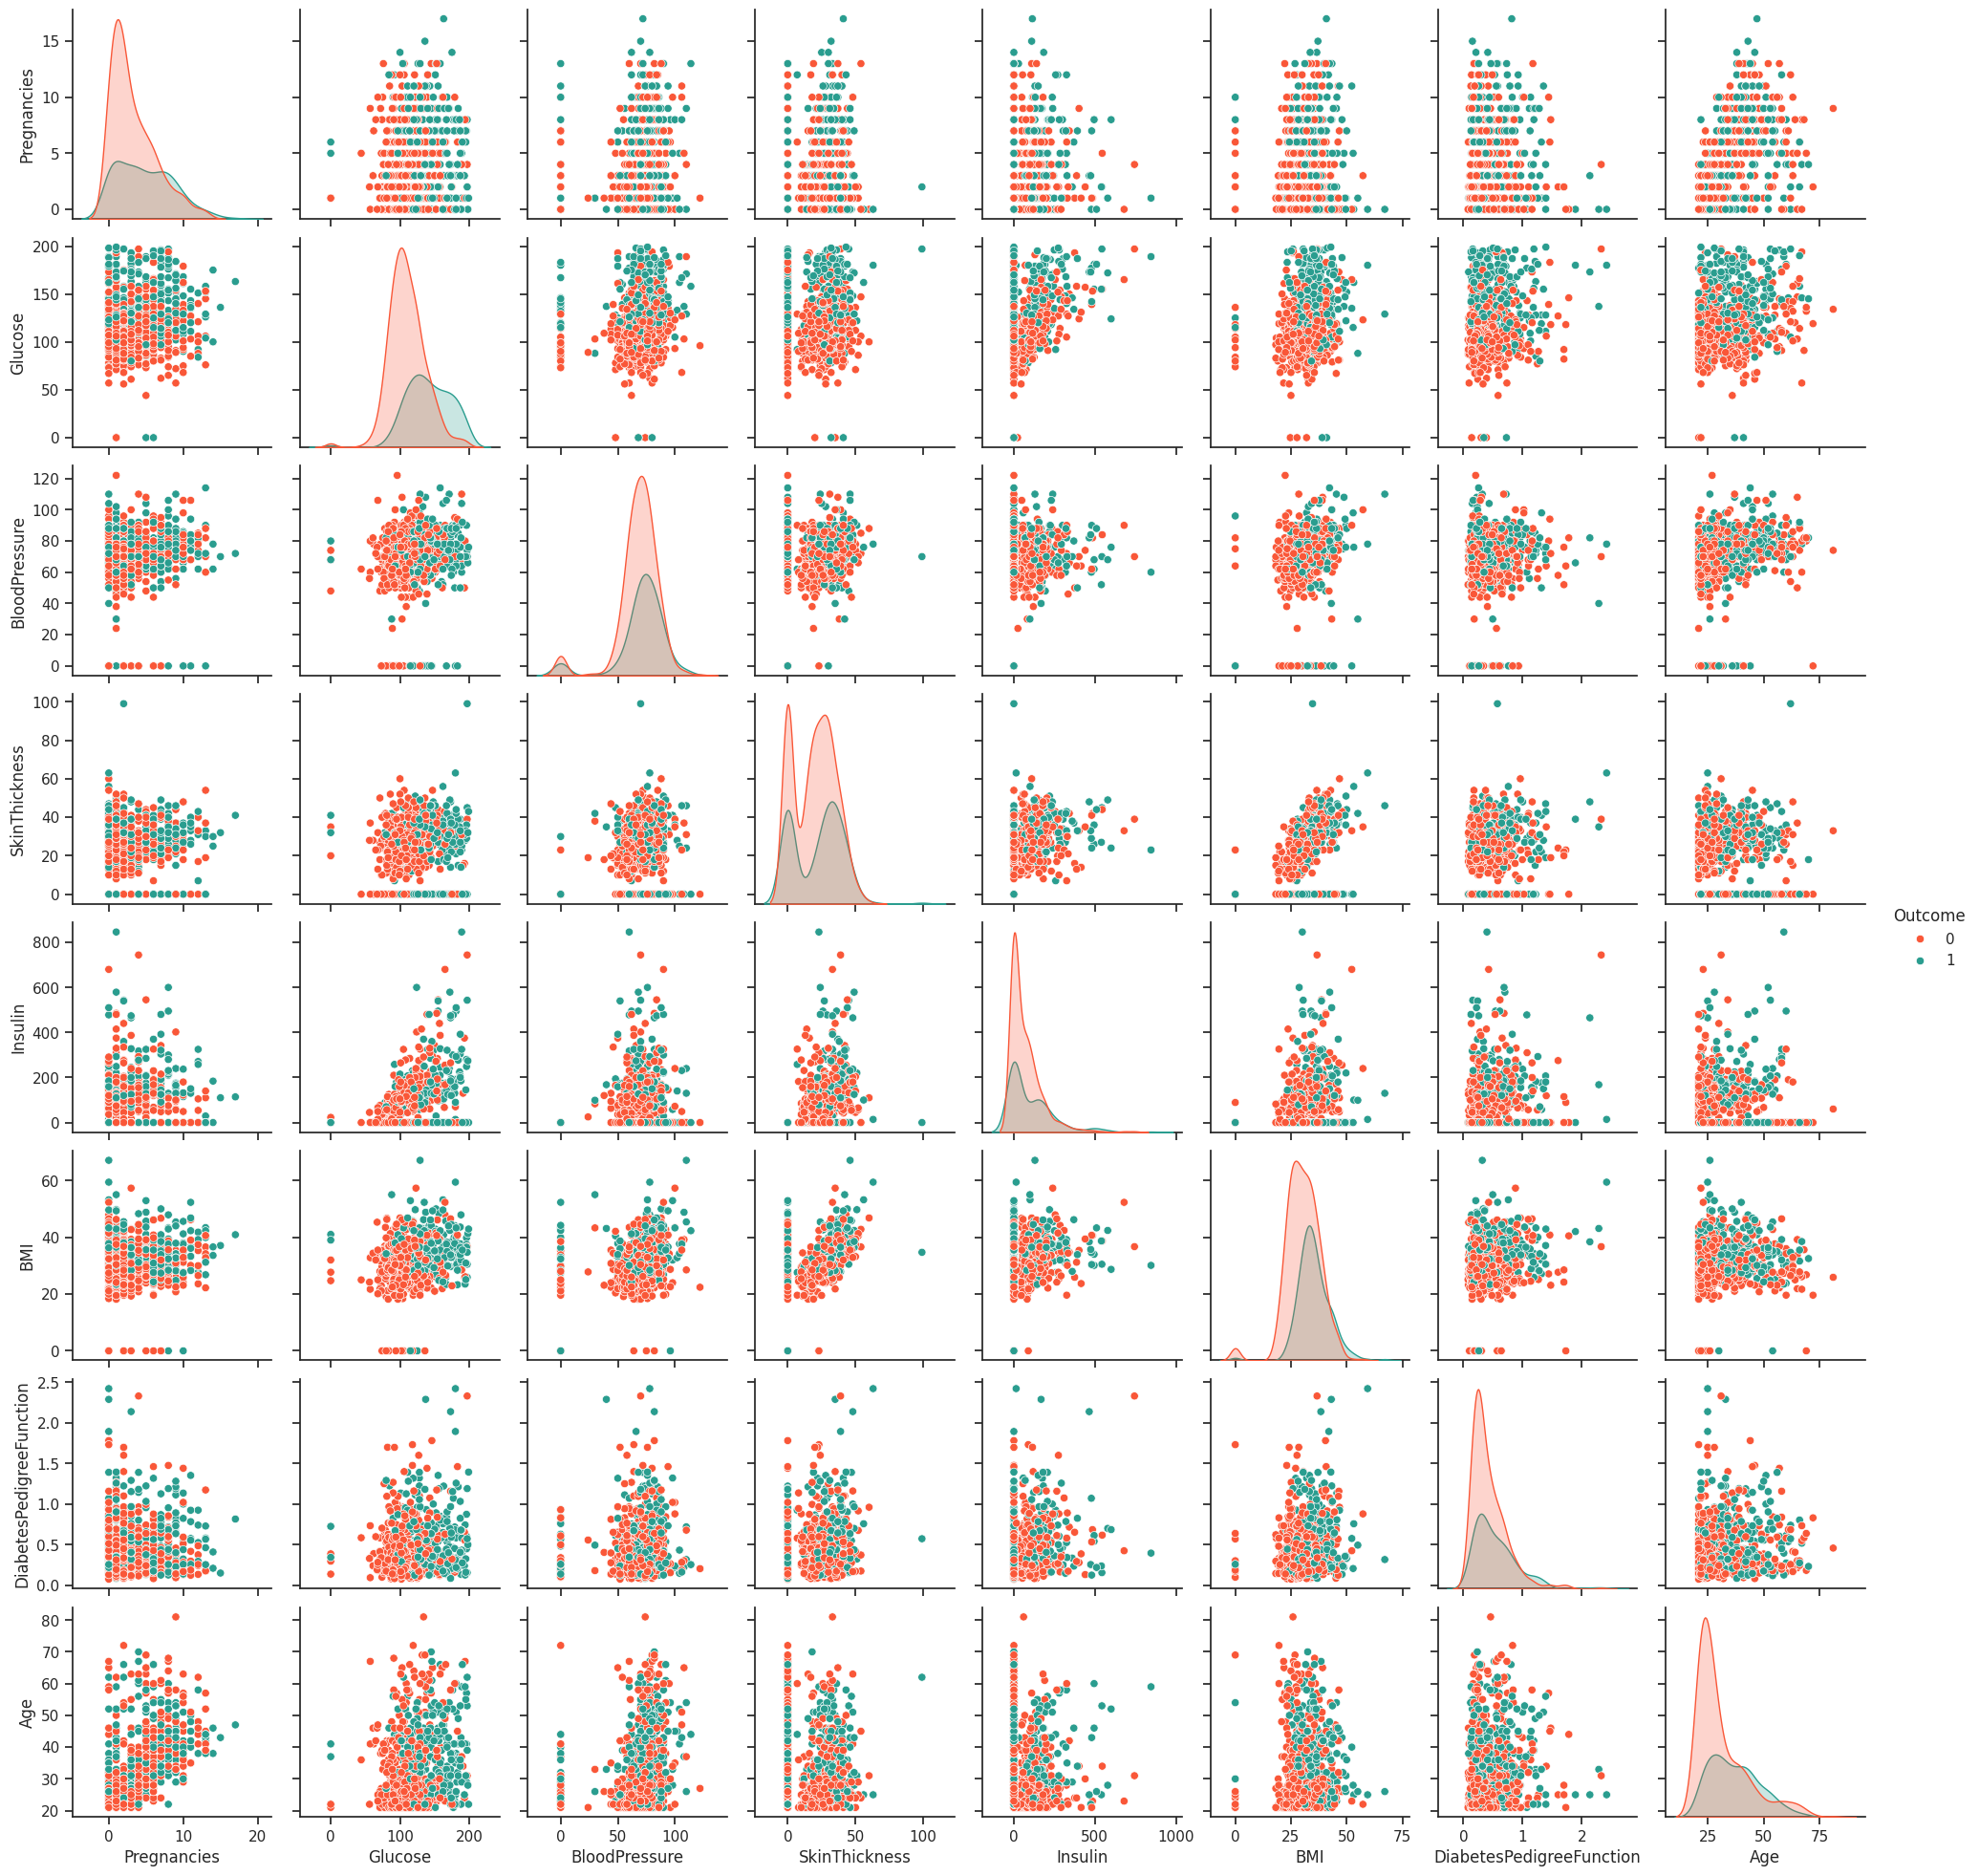

In [102]:
# Agregar la columna 'RainTomorrow' al DataFrame de columnas numéricas
variables = numeric_columns.append('Outcome')

# Crear el pairplot
sns.set(style="ticks")
sns.pairplot(diabetes_df, diag_kind='kde', hue='Outcome', palette={1: "#2a9d8f", 0: "#f95738"})
plt.show()

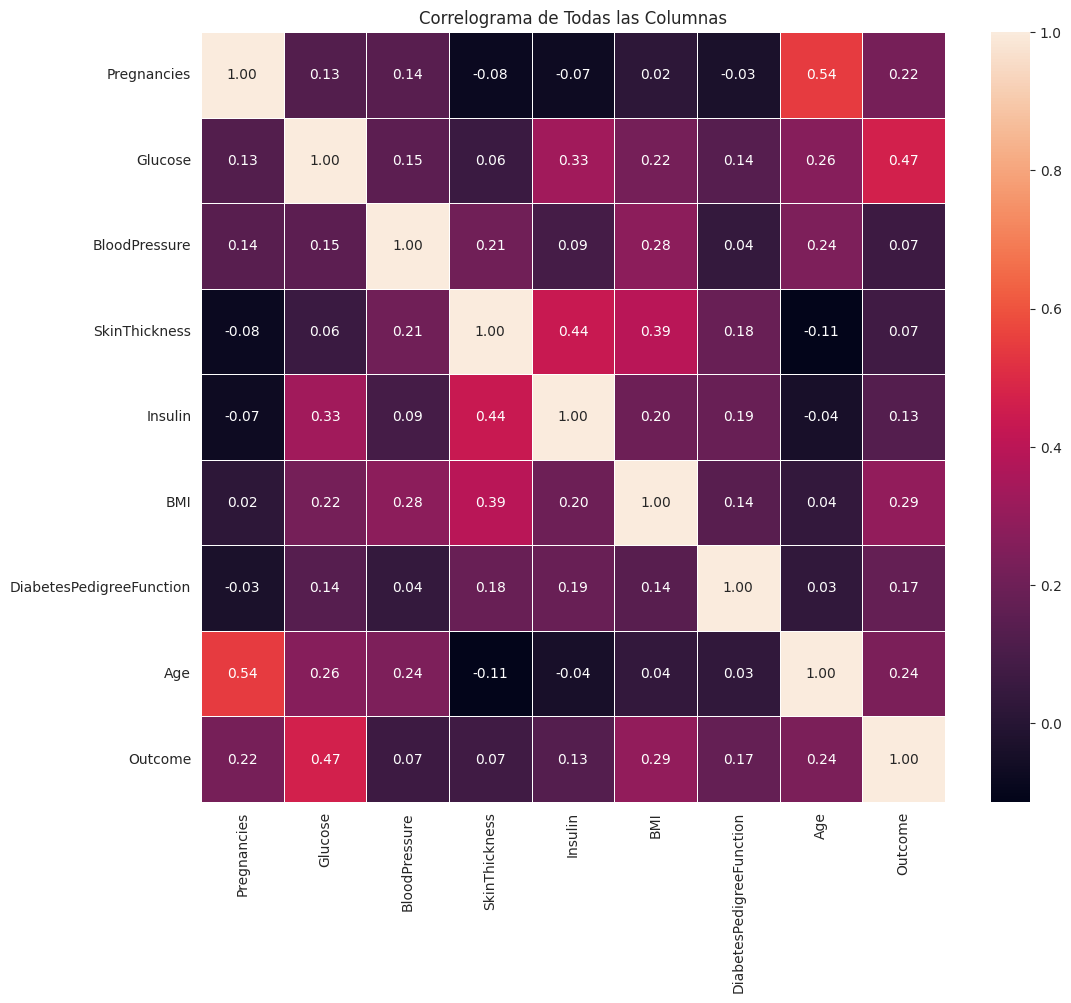

In [99]:
# Calcular la matriz de correlación
correlation_matrix = diabetes_df.corr()

# Crear un mapa de calor (correlograma)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='rocket', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlograma de Todas las Columnas')
plt.show()

Observaciones:

- Identificación de relaciones lineales: El nivel de glucosa es con gran diferencia, la variable que registra mayor correlación lineal con la variable respuesta (es decir, la presencia de diabetes). Luego siguen el índice de masa corporal y la edad con 0.29 y 0.24 respectivamente. Aunque el valor de correlación no es considerablemente significativo en ninguna de ellas, aún así podrían indicar que estas variables son importantes para predecir la diabetes y deberían ser consideradas en tu modelo. El resto de las variables poseen niveles bajos de correlación lineal. No indica necesariamente que deban ser descartadas del modelo, puesto que puede deberse a que estén correlacionadas de otra manera, que no es la líneal.

- Selección de características: El valor más elevado de correlación entre las variables explicativas se ha obtenido entre la edad y la cantidad de embarazos (0.54) siendo un resultado razonable puesto que existe una franja étarea para la cual es posible concebir. Otro valor de correlación que se destaca entre el resto es el valor de la insulin sérica y el espesor de la piel. Variables altamente correlacionadas entre sí pueden proporcionar información redundante para el modelo. En tal caso, se podría optar por eliminar una de las variables altamente correlacionadas para evitar la multicolinealidad en el mismo. En este escenario, si bien se registra colinealidad, no se considera que se encuentren en un valor que justifique la eliminación de alguna variable en el modelo.


### 1.5 - Variable respuesta

#### 1.5.1 - Balance de Datos
A continuación se muestra la proporción de datos en las cuales la variable objetivo indica que se diagnostica diabetes y las que no.

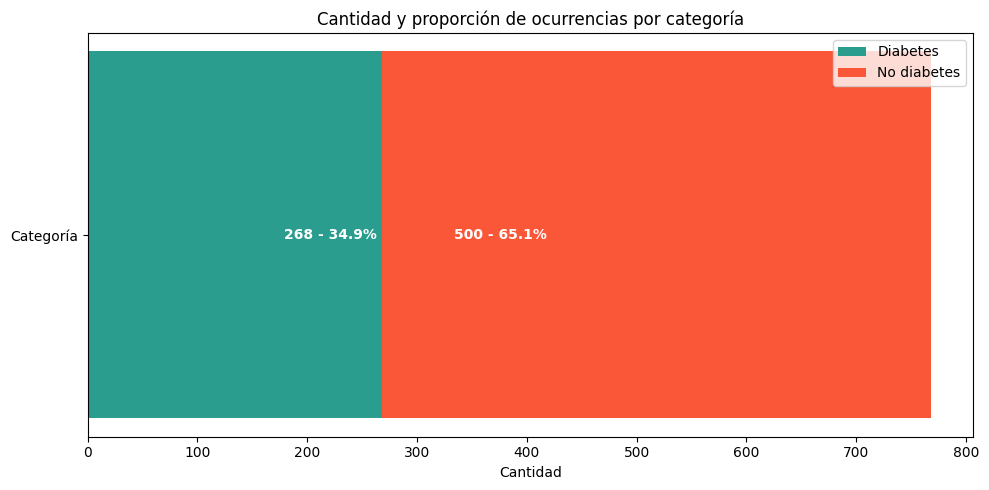

In [41]:
# Datos
diabetes_values = ['Diabetes', 'No diabetes']
diabetes = diabetes_df[diabetes_df['Outcome'] == 1]['Outcome'].count()
no_diabetes = diabetes_df[diabetes_df['Outcome'] == 0]['Outcome'].count()
total = diabetes + no_diabetes
amount = [diabetes, no_diabetes]
colors = ['#2a9d8f', '#f95738']

# Configuración de la figura
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Función para apilar
def apilar_amount(amount, index):
  if index == 0:
    return 0
  else:
    return sum(amount[:index])

for i, value in enumerate(diabetes_values):
   # Crear la barra
    bar = ax.barh('Categoría', amount[i], left=apilar_amount(amount, i), color=colors[i], label=value)

    # Añadir el valor de la barra
    for b in bar:
        width = b.get_width()
        plt.text(width/1.5, b.get_y() + b.get_height()/2, f'{amount[i]} - {round((amount[i]/total)*100, 2)}%', va='center', ha='left', fontsize=10, color='white', fontweight='bold')
        print()
    ax.set_title('Cantidad y proporción de ocurrencias por categoría')
    ax.set_xlabel('Cantidad')
    ax.legend()
# Mostrar gráfico
plt.tight_layout()
plt.show()

El dataset no está balanceado, teniendo un 65.1% de casos de no diabetes y 34.9% de casos de diabetes.

#### 1.5.2 - Relación de las variables explicativas respecto a la variable respuesta Outcome (indica diabetes o no)

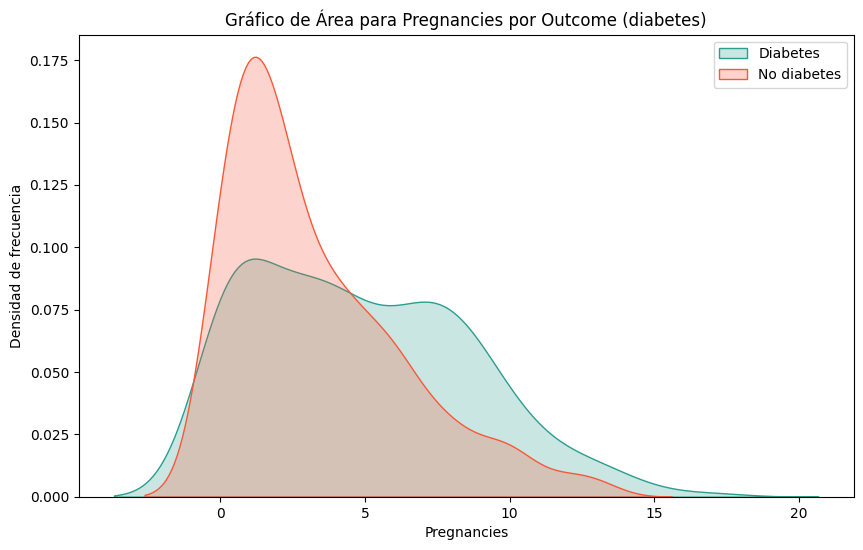

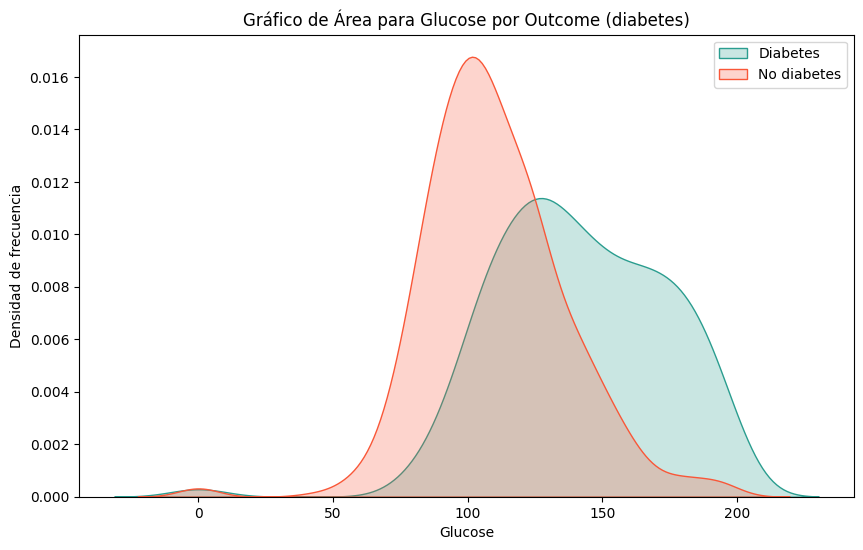

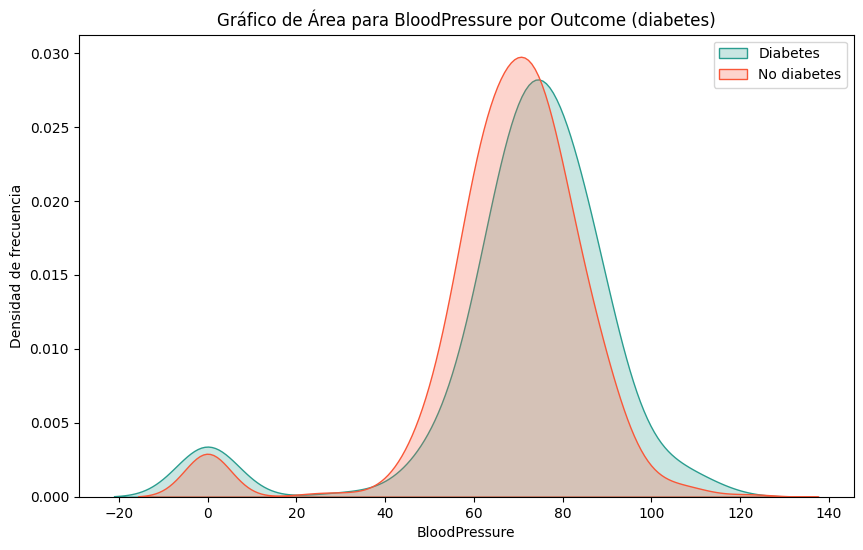

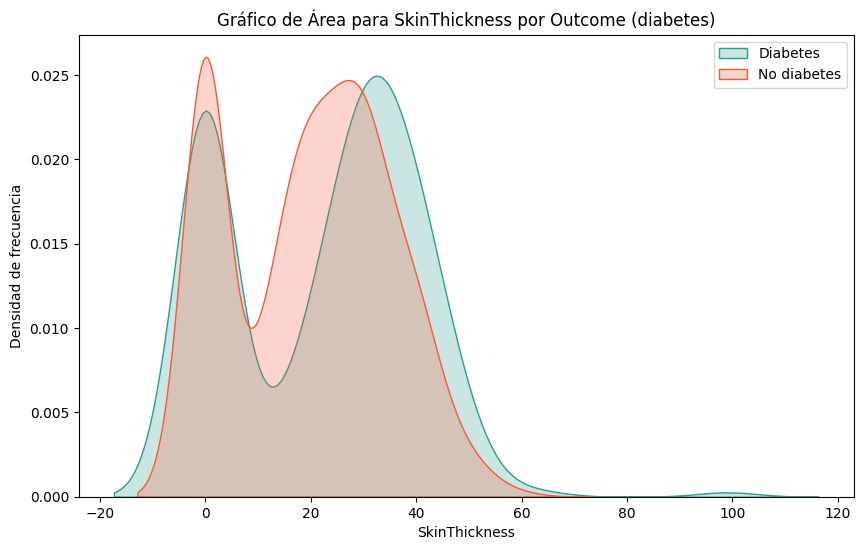

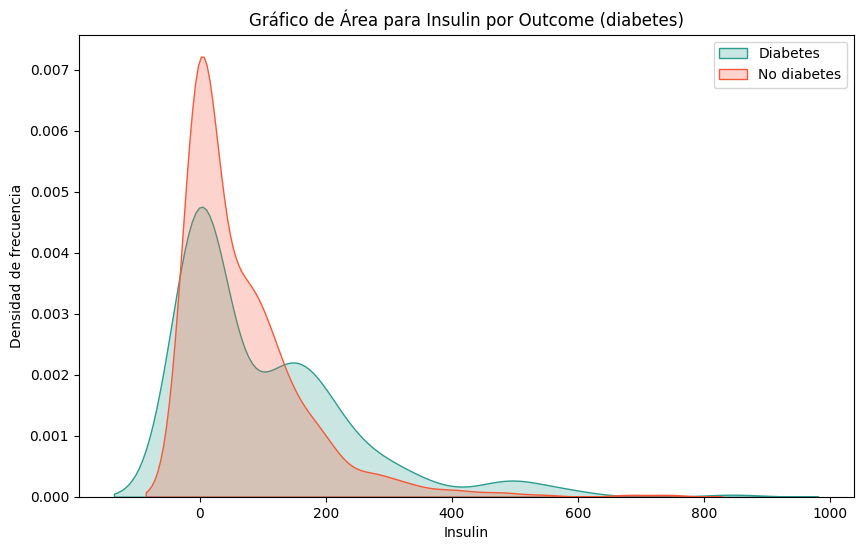

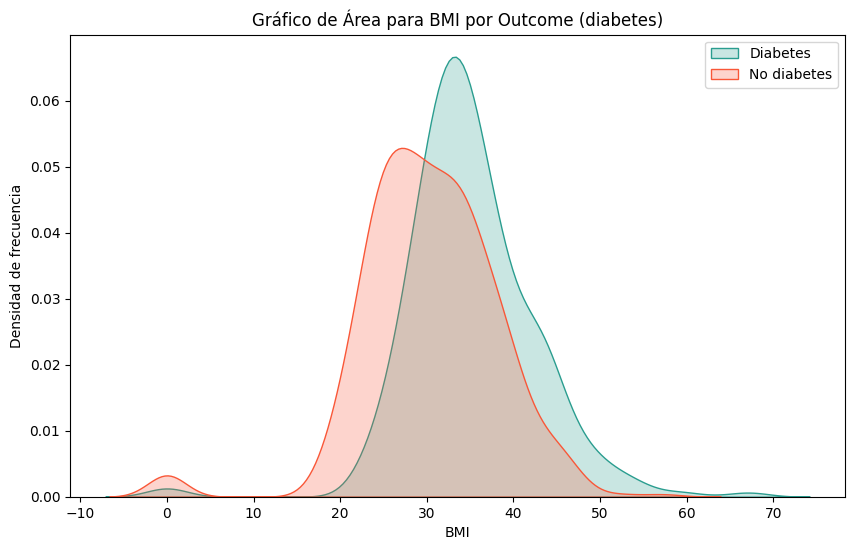

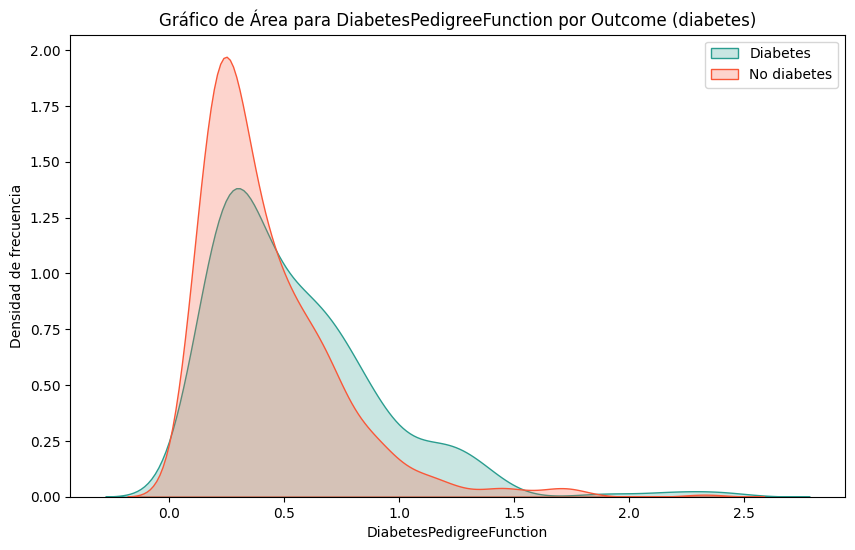

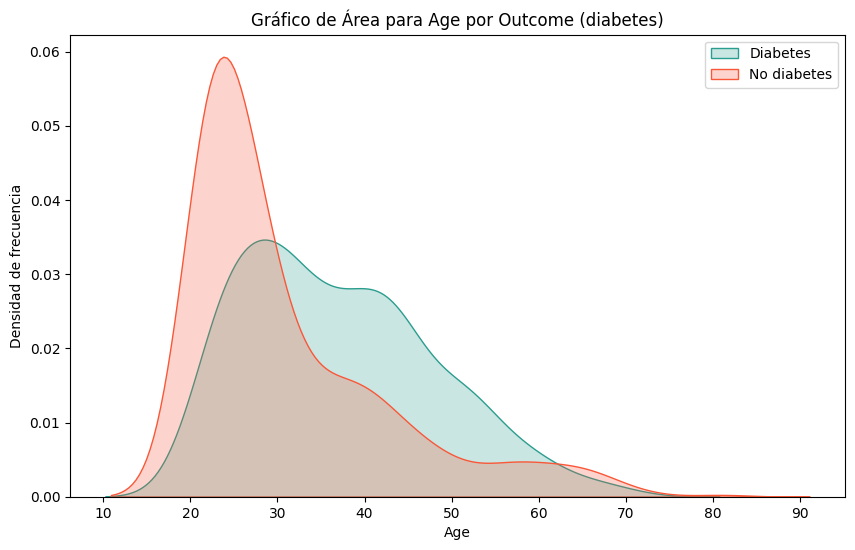

In [42]:
# Crear gráficos de área superpuestos para cada columna numérica
for column in numeric_columns:

    plt.figure(figsize=(10, 6))

    # Convertir la columna al tipo de datos numérico
    numeric_column = pd.to_numeric(diabetes_df[column], errors='coerce')

    # Gráfico de área para "Yes"
    sns.kdeplot(data=numeric_column[diabetes_df['Outcome'] == 1], label='Diabetes', shade=True, color='#2a9d8f')

    # Gráfico de área para "No"
    sns.kdeplot(data=numeric_column[diabetes_df['Outcome'] == 0], label='No diabetes', shade=True, color='#f95738')

    plt.title(f'Gráfico de Área para {column} por Outcome (diabetes)')
    plt.xlabel(column)
    plt.ylabel('Densidad de frecuencia')
    plt.legend()  # Agregar leyenda

    # Mostrar el gráfico
    plt.show()


Se observa que no hay una variable que permita distinguir claramente entre si se diagnostica diabetes o no. Los gráficos para ambas opciones mayormente se enciman y comparten los valores del eje x.

## 2 - Procesamiento de datos

In [68]:
for column in numeric_columns:
    print(f'Variable {column}')
    print(f'Cantidad de valores negativos: ', diabetes_df[diabetes_df[f'{column}'] < 0 ][column].count())
    print(f'Cantidad de valores iguales a cero: ', diabetes_df[diabetes_df[f'{column}'] == 0 ][column].count())
    print(f'Valor mínimo distinto de cero: ', diabetes_df[diabetes_df[f'{column}'] != 0 ][column].min())
    print(f'Valor máximo: ', diabetes_df[column].max())
  
    print('\n')

print(f'Variable respuesta: Diabetes o no diabetes')
print(f'Cantidad de valores negativos: ', diabetes_df[diabetes_df['Outcome'] < 0 ]['Outcome'].count())
print(f'Cantidada de valores mayores a 1: ', diabetes_df[diabetes_df['Outcome'] > 1 ]['Outcome'].count())

Variable Pregnancies
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  111
Valor mínimo distinto de cero:  1
Valor máximo:  17


Variable Glucose
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  5
Valor mínimo distinto de cero:  44
Valor máximo:  199


Variable BloodPressure
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  35
Valor mínimo distinto de cero:  24
Valor máximo:  122


Variable SkinThickness
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  227
Valor mínimo distinto de cero:  7
Valor máximo:  99


Variable Insulin
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  374
Valor mínimo distinto de cero:  14
Valor máximo:  846


Variable BMI
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  11
Valor mínimo distinto de cero:  18.2
Valor máximo:  67.1


Variable DiabetesPedigreeFunction
Cantidad de valores negativos:  0
Cantidad de valores iguales a cero:  

- Presión arterial diastólica: La presión arterial diastólica puede variar ampliamente entre individuos y puede ser tan baja como 0 mm Hg en casos extremos, como en situaciones de shock. Sin embargo, en un contexto de salud normal, es poco probable que alguien tenga una presión arterial diastólica de 0 mm Hg. Los valores típicos se encuentran dentro del rango de 60-80 mm Hg, pero pueden variar según la edad, la condición física y otros factores. Valores de 0 podrían indicar un problema con la medición o un estado de salud muy anormal.

- Espesor del pliegue cutáneo del tríceps: El espesor del pliegue cutáneo del tríceps puede variar ampliamente entre individuos y puede ser de 0 mm en personas con un bajo porcentaje de grasa corporal o en situaciones específicas, pero generalmente no debería ser comúnmente 0. Valores de 0 podrían indicar un error de medición o la necesidad de una evaluación adicional para determinar su validez.

- Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia oral a la glucosa: Normalmente, la concentración de glucosa en plasma a las 2 horas después de una prueba de tolerancia oral a la glucosa debería ser mayor que cero en individuos sin y con diabetes. Un valor de cero podría indicar una ausencia de respuesta al consumo de glucosa, lo cual es poco probable en un contexto de salud normal.

- Insulina sérica a las 2 horas: La insulina sérica a las 2 horas después de una comida es un indicador de la respuesta del cuerpo a la glucosa. Un valor de cero para la insulina sérica a las dos horas podría indicar varios escenarios posibles:

    1. Error de medición: Podría haber habido un error en la toma de la muestra de sangre o en el análisis de       laboratorio que resultó en un valor incorrecto.
    2. Disfunción pancreática grave: En casos extremadamente raros de disfunción pancreática grave, como en la pancreatitis severa o la insuficiencia pancreática, es posible que la secreción de insulina esté significativamente disminuida o ausente, lo que podría resultar en un valor cercano a cero. Sin embargo, este escenario sería poco común y generalmente estaría asociado con otras manifestaciones clínicas graves.
    3. Omisión de la insulina exógena: Si el paciente está tomando insulina exógena como tratamiento para la diabetes y no se ha tenido en cuenta en el momento del análisis, podría resultar en un valor de cero para la insulina sérica.

- BMI (Índice de masa corporal): El BMI se calcula dividiendo el peso en kilogramos por el cuadrado de la altura en metros. Aunque una persona puede tener un BMI bajo, es poco probable que sea exactamente cero, incluso en casos extremadamente delgados.

- Función de pedigree de la diabetes: Este valor evalúa la probabilidad de diabetes basada en antecedentes familiares. No tiene un rango específico, pero es poco probable que sea cero ya que estaría indicando una probabilidad nula de diabetes basada en antecedentes familiares, lo cual es poco común.

En resumen, los valores de cero para estas variables podrían indicar errores de medición, valores faltantes o condiciones de salud anormales.

Dadas las aclaraciones médicas anteriores, se entiende que los escenarios para que dichas variables presenten valores de 0 son muy poco probables o inexistentes. Es así que se reemplazarán los valores de cero en dichas variables con NaN y luego se utilizará un imputador de KNN para imputar los datos, buscando de esta forma, mantener el volumen de datos original para evaluar la mayor cantidad de datos posibles en el modelo y obtener más representatividad poblacional.

Dicha imputación se llevará a cabo luego de dividir el set de datos en conjuntos de entrenamiento y prueba ya que se pretende evitar que las asignaciones de valores tanto para el conjunto de entrenamiento y de test se vean influenciadas entre sí. Se busca una clara separación de los datos y no relacionar sus valores mediante las imputaciones.

In [70]:
# Lista de columnas en las que deseas reemplazar los valores iguales a cero por NaN
columnas_a_reemplazar = ['Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI']

# Reemplazar los valores iguales a cero por NaN en las columnas especificadas
diabetes_df[columnas_a_reemplazar] = diabetes_df[columnas_a_reemplazar].replace(0, float('nan'))


In [72]:
# Comprobamos que no haya ninguna medición, para dichas columnas, que tomen el valor 0
for column in columnas_a_reemplazar:
    print(f'Variable {column}')
    print(f'Cantidad de valores iguales a cero: ', diabetes_df[diabetes_df[f'{column}'] == 0 ][column].count())
  
    print('\n')

# Verificar si hay NaN en las columnas especificadas
nan_values = diabetes_df[columnas_a_reemplazar].isna().any()

# Mostrar las columnas que contienen NaN
columnas_con_nan = nan_values[nan_values == True].index.tolist()
print("Columnas con NaN:", columnas_con_nan)



Variable Glucose
Cantidad de valores iguales a cero:  0


Variable BloodPressure
Cantidad de valores iguales a cero:  0


Variable SkinThickness
Cantidad de valores iguales a cero:  0


Variable Insulin
Cantidad de valores iguales a cero:  0


Variable BMI
Cantidad de valores iguales a cero:  0


Columnas con NaN: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


## 3 - Modelo de clasificación con RNN

### 3.1 - Separar conjuntos de entrenamiento y de prueba

In [103]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(diabetes_df.drop('Outcome', axis=1),
                                                   diabetes_df['Outcome'].values.reshape(-1, 1),
                                                   test_size=0.2,
                                                   random_state=7)

In [77]:
type(X_train)

pandas.core.frame.DataFrame

In [104]:
# Se observa que la columna respuesta haya sido removida de los datos de entrenamiento y test
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
289,5,108,72,43,75,36.1,0.263,33
328,2,102,86,36,120,45.5,0.127,23
394,4,158,78,0,0,32.9,0.803,31
321,3,112,74,30,0,31.6,0.197,25
326,1,122,64,32,156,35.1,0.692,30


In [105]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,43,27.2,0.580,24
236,7,181,84,21,192,35.9,0.586,51
323,13,152,90,33,29,26.8,0.731,43
98,6,93,50,30,64,28.7,0.356,23
701,6,125,78,31,0,27.6,0.565,49


### 3.2 - Imputar columnas numéricas utilizando K-Nearest Neighbors (K-NN)


El método de imputación de KNN (K-Nearest Neighbors) de scikit-learn es una técnica de imputación que se basa en el principio de que los valores faltantes en un conjunto de datos pueden ser estimados utilizando los valores de los vecinos más cercanos en función de la distancia entre las observaciones

La función actúa de la siguiente manera:

1. Para cada valor faltante en el conjunto de datos, se encuentra la distancia entre esa observación y todas las demás observaciones en el conjunto de datos.

2. Se seleccionan las k (parámetro de la función)observaciones más cercanas (vecinos) a la observación con datos faltantes en función de la distancia calculada.

3. Se utiliza la información de los valores de las k observaciones vecinas para estimar el valor faltante. En scikit-learn, el método KNNImputer para imputación de valores faltantes utiliza el promedio ponderado de los k vecinos más cercanos para estimar el valor faltante.

4. El valor estimado se imputa en lugar del valor faltante en el conjunto de datos.

In [106]:
# Crea una instancia del imputador K-NN con el número deseado de vecinos (neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Aplica el imputador a las columnas seleccionadas
X_train[columnas_con_nan] = knn_imputer.fit_transform(X_train[columnas_con_nan])

# Datos faltantes antes
missing_data = X_train.isnull().sum()
print("Datos faltantes por columna luego de la imputación:")
print(missing_data)

Datos faltantes por columna luego de la imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


Se repite el proceso con los datos de test

In [107]:
# Crea una instancia del imputador K-NN con el número deseado de vecinos (neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Aplica el imputador a las columnas seleccionadas
X_test[columnas_con_nan] = knn_imputer.fit_transform(X_test[columnas_con_nan])

# Datos faltantes antes
missing_data = X_test.isnull().sum()
print("Datos faltantes por columna luego de la imputación:")
print(missing_data)

Datos faltantes por columna luego de la imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


In [82]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3.3 - Utilizar SMOTE (Synthetic Minority Over-sampling Technique) para corregir el desbalance de clases

Como se observó anteriormente en la sección de análisis exploratorio, las clases del dataset (diabetes y no diabetes) están altamente desbalanceadas.

El método SMOTE (Synthetic Minority Over-sampling Technique) es una técnica que genera muestras sintéticas de la clase minoritaria. El proceso es el siguiente:

1. **Selección de una instancia minoritaria**: Para aplicar SMOTE, primero se elige una instancia de la clase minoritaria en el conjunto de datos desequilibrado.

2. **Selección de vecinos cercanos**: Luego, SMOTE selecciona k vecinos cercanos a esta instancia. El valor de k se elige de antemano y se utiliza para determinar cuántas instancias sintéticas se generarán.

3. **Generación de instancias sintéticas**: Para crear una instancia sintética, SMOTE elige uno de los k vecinos cercanos y calcula la diferencia entre la instancia seleccionada inicialmente y el vecino elegido. Luego, multiplica esta diferencia por un número aleatorio entre 0 y 1 y lo suma a la instancia inicial. Esto crea una nueva instancia en el espacio de características que se encuentra a lo largo de la línea que conecta la instancia inicial y el vecino seleccionado.

4. **Repetición del proceso**: Este proceso se repite para cada instancia minoritaria en el conjunto de datos, generando un conjunto de datos equilibrado con un número igual de instancias en ambas clases.

In [108]:
# Contar la cantidad de filas con el valor "1" en la columna "RainTomorrow_Yes"
cantidad_1 = len(diabetes_df[diabetes_df['Outcome'] == 1])

# Contar la cantidad de filas con el valor "0" en la columna "Outcome"
cantidad_0 = len(diabetes_df[diabetes_df['Outcome'] == 0])

print("Cantidad de filas con 'Outcome' igual a 1:", cantidad_1)
print("Cantidad de filas con 'Outcome' igual a 0:", cantidad_0)

Cantidad de filas con 'Outcome' igual a 1: 268
Cantidad de filas con 'Outcome' igual a 0: 500


Podemos ver que está muy desbalanceado, por lo que debe utilizarse un método de balanceo de clases como asignar pesos diferentes, oversampling o undersampling.

In [109]:
# Crear una instancia de SMOTE
smote = SMOTE()

# Aplicar SMOTE al conjunto de entrenamiento para aumentar las instancias de la clase minoritaria
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [110]:
# Contar la cantidad de 1 y 0 en y_train_resample
count_1 = np.bincount(y_train_resampled)[1]  # Cuenta la cantidad de 1
count_0 = np.bincount(y_train_resampled)[0]  # Cuenta la cantidad de 0

print(f"Cantidad de 1 en y_train_resample: {count_1}")
print(f"Cantidad de 0 en y_train_resample: {count_0}")

Cantidad de 1 en y_train_resample: 403
Cantidad de 0 en y_train_resample: 403


Ahora puede verse como el dataset de entrenamiento está balanceado

### 3.4 - Visualizar distribuciónes de características

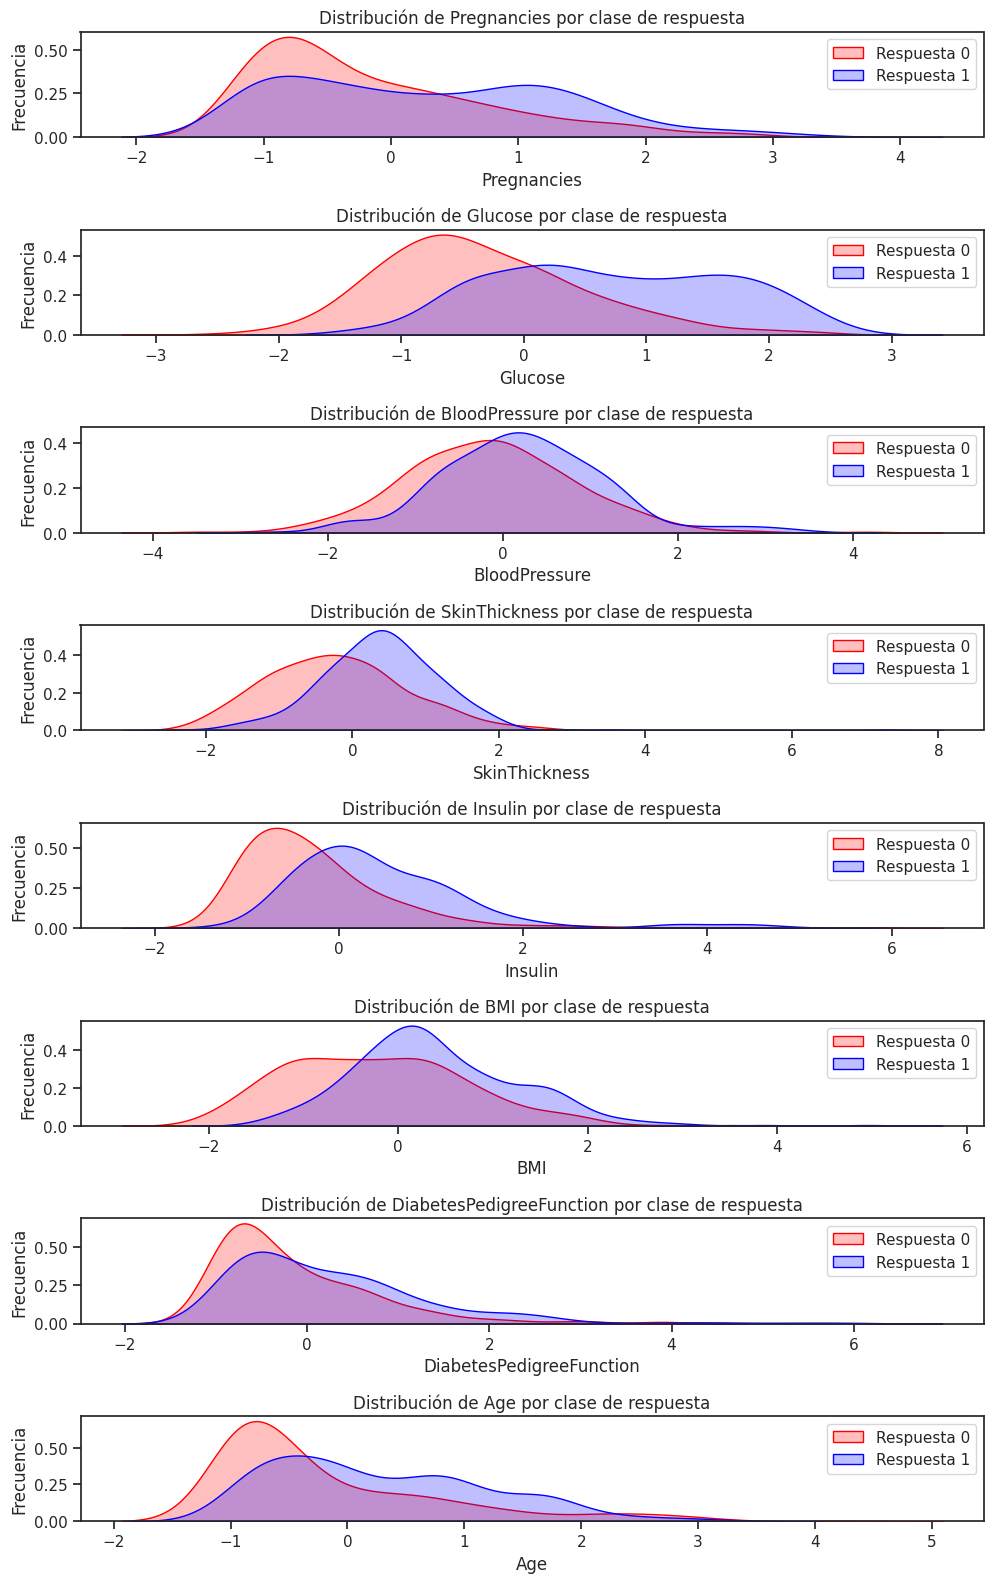

In [111]:
# Crear DataFrames a partir de los arreglos NumPy
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['Response'])

# Concatenar los DataFrames horizontalmente
data = pd.concat([X_train_resampled_df, y_train_resampled_df], axis=1)


# Obtener las características
features = data.columns[:-1]

# Colores para las áreas (rojo y azul)
colors = ['red', 'blue']

# Crear una figura con subgráficos para cada característica
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(10, 2 * len(features)))

# Iterar a través de las características
for i, feature in enumerate(features):
    # Dividir los datos según la variable respuesta (0 y 1)
    for response_value, color in zip([0, 1], colors):
        subset = data[data['Response'] == response_value]
        sns.kdeplot(data=subset, x=feature, ax=axes[i], fill=True, color=color, label=f'Respuesta {response_value}')

    # Configuraciones del gráfico
    axes[i].set_title(f'Distribución de {feature} por clase de respuesta')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend(loc='best')

# Ajustar el espacio entre los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Observando las distribuciones de features según su respuesta se puede notar que muchas de ellas están muy unidas para ambas respuestas y no presentan una clarisima distinción. La concentración de glucosa (Glucosed) es una característica que está más cercana a marcar una ligera distinción entre las clases de la variable respuesta, por lo que puede ser una variable importante para el modelo.

### 3.5 - Redes neuronales para la clasificación

In [112]:
def build_binary_classification_model(num_layers, num_neurons):
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, activation='relu', input_shape=(X_train_resampled.shape[1],)))

    for _ in range(num_layers - 1):
        model.add(keras.layers.Dense(num_neurons, activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [113]:
# Configurar la validación cruzada k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [114]:
# Probar diferentes configuraciones de capas y neuronas
for num_layers in [1, 2, 3]:
    for num_neurons in [32, 64, 96]:
        print(f'\nConfiguración: Capas={num_layers}, Neuronas por capa={num_neurons}')

        # Almacenar métricas para todas las iteraciones
        accuracy_scores = []
        f1_scores = []
        precision_scores = []
        recall_scores = []

        # Iterar sobre las particiones y entrenar/evaluar el modelo
        for train_index, val_index in kf.split(X_train_resampled):
            X_train_nnc, X_val_nnc = X_train_resampled[train_index], X_train_resampled[val_index]
            y_train_nnc, y_val_nnc = y_train_resampled[train_index], y_train_resampled[val_index]

            # Construir y entrenar el modelo de clasificación binaria
            model = build_binary_classification_model(num_layers, num_neurons)
            model.fit(X_train_nnc, y_train_nnc, epochs=50, batch_size=32, verbose=0)

            # Obtener predicciones y convertir probabilidades a etiquetas binarias
            predictions_prob = model.predict(X_val_nnc)
            predictions = (predictions_prob > 0.5).astype(int)

            # Calcular métricas de clasificación binaria
            accuracy = accuracy_score(y_val_nnc, predictions)
            f1 = f1_score(y_val_nnc, predictions)
            precision = precision_score(y_val_nnc, predictions)
            recall = recall_score(y_val_nnc, predictions)

            accuracy_scores.append(accuracy)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)

            print(f'Accuracy en conjunto de validación: {accuracy}')
            print(f'Precision en conjunto de validación: {precision}')
            print(f'Recall en conjunto de validación: {recall}')
            print(f'F1 Score en conjunto de validación: {f1}')

        # Imprimir la media de las métricas para todas las iteraciones
        print(f'Media de Accuracy: {np.mean(accuracy_scores)}')
        print(f'Media de Precision: {np.mean(precision_scores)}')
        print(f'Media de Recall: {np.mean(recall_scores)}')
        print(f'Media de F1 Score: {np.mean(f1_scores)}')


Configuración: Capas=1, Neuronas por capa=32


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy en conjunto de validación: 0.7530864197530864
Precision en conjunto de validación: 0.7631578947368421
Recall en conjunto de validación: 0.725
F1 Score en conjunto de validación: 0.7435897435897436
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy en conjunto de validación: 0.7577639751552795
Precision en conjunto de validación: 0.75
Recall en conjunto de validación: 0.6986301369863014
F1 Score en conjunto de validación: 0.723404255319149
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy en conjunto de validación: 0.782608695652174
Precision en conjunto de validación: 0.7857142857142857
Recall en conjunto de validación: 0.7951807228915663
F1 Score en conjunto de validación: 0.7904191616766467
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy en conjunto de validación: 0.7639751552795031
Precision en conjunto de validación: 0.7684210526315789
Recall en conjunto de validación: 0.8202247191011236
F1 Score en conjunto de validación: 0.7934782608695652
6

Se observa que, a medida que aumenta el número de capas y de neuronas, los valores de las métricas de rendimiento aumentan. También se observa que, a partir de los resultados para 2 capas y 64 neuronas, no existen cambios significativos en el rendimiento. Se considera viable tomar una complejidad de modelo de dos capas con 96 neuronas cada una, ya que se obtienen pequeñas mejoras en el rendimiento, en relación con parámetros de menor cantidad y, a su vez, no continuar aumentando el número de capas y neuronas puesto que, aunque hay mejoras en el rendimiento, se encuentra la posibilidad de caer en el overfitting.

En esta ocasión, dado que los fines de este proyecto son didácticos, se ha utilizado validación cruzada con KFold. Sin embargo, en otras circunstancias, no sería lo más conveniente, dado que el consumo de recursos computacionales y tiempo es elevado, haciendo su uso poco viable.

### 3.6 - Accuracy, Precision, Recall, F1-Score y matriz de confusión.

n° de parámetros: 10273
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Accuracy en conjunto de test: 0.7727
Precision en conjunto de test: 0.6719
Recall en conjunto de validación: 0.7544
F1 Score en conjunto de test: 0.7107


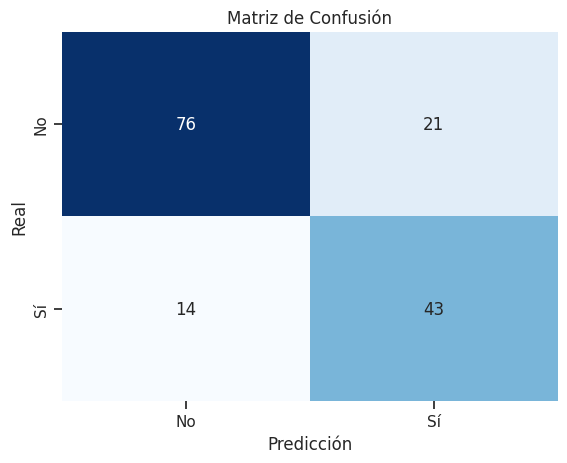

In [130]:
# Construir y entrenar el modelo de clasificación binaria
best_model = build_binary_classification_model(2, 96)
best_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, verbose=0)
print("n° de parámetros:", best_model.count_params())

# Evaluar el modelo final en el conjunto de prueba
test_predictions = best_model.predict(X_test_scaled)
predictions_test = (test_predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, predictions_test)
f1 = f1_score(y_test, predictions_test)
precision = precision_score(y_test, predictions_test)
recall = recall_score(y_test, predictions_test)

print(f'Accuracy en conjunto de test: {accuracy:.4f}')
print(f'Precision en conjunto de test: {precision:.4f}')
print(f'Recall en conjunto de validación: {recall:.4f}')
print(f'F1 Score en conjunto de test: {f1:.4f}')

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predictions_test)

# Visualizar la matriz de confusión con Seaborn
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

La exactitud indica que la proporción de predicciones correctas en el conjunto de datos es de 79%.

La precisión se refiere a la proporción de predicciones positivas que fueron correctas. Un valor de 0.6719 indica que el 67,19% de las predicciones positivas fueron correctas.

La sensibilidad mide la proporción de verdaderos positivos identificados correctamente en comparación con todos los casos positivos reales. Un valor de 0.7544 indica que se capturan el 75,44% de los casos positivos. Dado que la predicción de diabetes tiene un impacto significativo en la salud, planificación y toma de decisiones de los pacientes pra su via diaria, es importante que el modelo tenga una alta sensibilidad. En este caso, una alta sensibilidad significa que el modelo identificará la mayoría de las instancias en las que se diagnostica positivo para diabetes, minimizando los falsos negativos, lo que es crucial para garantizar que las personas estén preparadas para tomar las medidas necesarias para el cuidado de su salud.

El puntaje F1 es una métrica que combina precisión y recall en un solo número. Un valor de 0.7107 es bastante equilibrado y sugiere un buen equilibrio entre precisión y sensibilidad.

En general, el modelo tiene un buen rendimiento. La alta sensibilidad (recall) indica que el modelo es efectivo para identificar la mayoría de los casos positivos (diabetes), mientras que la precisión razonable sugiere que las predicciones positivas son en su mayoría correctas. El puntaje F1 de 0.7107 indica un equilibrio entre precisión y recall. Con un recall (sensibilidad) de 0.7544 y una precisión de 0.6719, parece que el modelo tiene una buena capacidad para identificar pacientes con diabetes, pero también emite algunas falsas alarmas.

Pero para evaluar de manera más completa el modelo hay que tener en cuenta la curva ROC (Receiver Operating Characteristic) y el AUC (Area Under the Curve).

### 3.7 - ROC (Receiver Operating Characteristic) y  AUC (Area Under the Curve)
La curva ROC es una representación gráfica que se utiliza para evaluar el rendimiento de un clasificador binario en función de sus umbrales de decisión. La curva muestra la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos (1 - especificidad) a medida que se varía el umbral de decisión.

El AUC, o Área Bajo la Curva, es un valor numérico que se calcula a partir de la curva ROC. Representa la medida de rendimiento global de un clasificador binario. Cuanto mayor sea el AUC, mejor será el rendimiento del clasificador.


In [131]:
# Calculo la ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions_test)
roc_auc = auc(fpr, tpr)

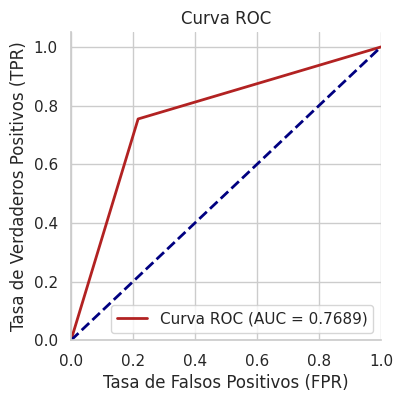

In [132]:
# Grafico la curva ROC
plt.figure(figsize=(4, 4))
sns.set(style="whitegrid")
plt.plot(fpr, tpr, color='firebrick', lw=2, label='Curva ROC (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
sns.despine()
plt.show()

In [133]:
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.7689


Un AUC de 0.7689 está aceptablemente próximo a 1, lo que significa que el modelo tiene un alto grado de separación entre las dos clases (diabetes y no diabetes) en términos de sus probabilidades predichas. Esto indica la capacidad del modelo para clasificar correctamente la mayoría de las instancias, lo cual es fundamental en la predicción de diabetes, donde la sensibilidad es una métrica importante.